In [69]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
sys.path.append('./include')
import ml4s
import json
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Quantum Many Body Problem
## Casey Sobecks
### Working from "Solving the Quantum Many Body Problem using Artificial Neural Networks" by Carleo and Troyer $[1]$

The quantum many body problem can be descriped as the problem of predicting the properties of systems of several quantum particles from the first principles of quantum mechanics.$[5]$ It is a general topic that covers many fields in Physics. It ranges from solid-state physics, superfluidity, molecular physics, atomic physics, nuclear structures, nuclear reactions, hadron spectroscopy, and quark-gluon plasma. $[4]$ Specific to solid-state physics, the study of high and low superconductivity is a popular many body problem.  

With this problem appearing across many fields of physics, it is beneficial to find a quick way to solve these systems. One method of interest is using an artificial neural network to solve the problem.

## Neural-Network Quantum States (NQS)
The problem above can be considered as a system with N discrete-valued degrees of freedom. These values can be anything, but in this case they will be spin. Denote these as $\mathcal{S}=(\mathcal{S}_1,\mathcal{S}_2 ... \mathcal{S}_{\mathcal{N}})$. In this system, the spins are restricted to be $\frac{1}{2}$ spin. The architecture of this system can be realized with a restricted Boltzmann machine. Graphically, the architecture is set up in the following image.

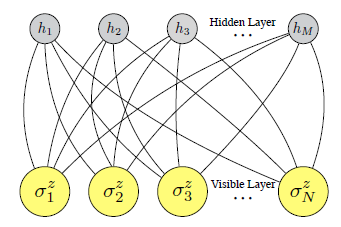

In [70]:
Image("fig1.png")

From source $[1]$

The neural network is composed of $\mathcal{N}$ visible layers and $\mathcal{M}$ hidden layers. The $\mathcal{N}$ layers represent the physical spin of the system. The $\mathcal{M}$ layers are auxilary spin variables, denoted in the figure as $(h_1...h_M)$. The variational expression for this system is given by the following equation.

$\Psi_M(\mathcal{S};\mathcal{W})=\sum_{\{h_i\}}\exp(\sum_j a_j \sigma_j^z+\sum_i b_i h_i + \sum_{ij} W_{ij} h_i \sigma_j^z)$

From this equation the weights can be defined as $\mathcal{W}=\{a_i,b_j,W_{ij}\}$. These weights fully specify the response of the network to some input state $\mathcal{S}$. In order to account for the amplitude and phase of the wave equation, the weights should be complex numbers. Since there are also no intra-layer interactions, the hidden variables can be explicitly traced out. This means that the variational equation can be simplified to the following equation.

$\Psi_M(\mathcal{S};\mathcal{W})=\exp(\sum_j a_j \sigma_j^z)\times \prod_{i=1}^M (2\cosh(b_i+\sum_j W_{ij} \sigma_j^z)$

This simplification will be very useful for the optimization of the weights.

In [71]:
def crand(N):
    x=(np.random.random(N)-0.5)*0.01
    y=(np.random.random(N)-0.5)*0.01
    z=x+1j*y
    return z   

In [72]:
N=14
alpha=2
h=2
M=alpha*N
a,b,W=crand(N),crand(M),crand((N,M))
S=np.random.randint(2,size=N)
S[S==0]=-1
S_i=list(range(N))

## Stochastic Reconfiguration (SR)
In order to see how accuracte the NQS method is, a test can be constructed to find the ground state energy. To do these calculations, a quantum Hamiltonian is needed. The reference provides two different Hamiltonians. 

Transverse-field Ising: $\mathcal{H}_{TFI}=-h\sum_i \sigma_i^x-\sum_{<i,j>} \sigma_i^z \sigma_j^z$

Here, the left term is the spin of the current state and the right term is the spin of the neighboring states. The $\sigma$ terms are the usual pauli matrices. The constant h is a term that comes from the field and can be changed to test for different field strengths. According to the the paper, the hardest term to solve for is h=1, so this number will be avoided. The architecture of this Hamiltonian can be seen from a Markov Chain with periodic boundary conditions, shown in the following figure. 


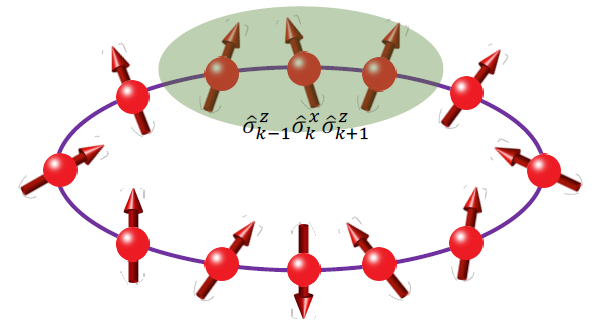

In [73]:
Image('fig2.png')

From source $[2]$

This Hamiltonian can be realized using the following 

In [74]:
def E_loc(S,a,b,W):
    E=0

    #nearest neighbors, \sigma^z
    for i in S_i:
        if i==N-1: 
            E-=(S[i]*S[0])
        else: 
            E-=(S[i]*S[i+1])
    
    #state spin, \sigma^x
    Psi_S=Psi_M(S,a,b,W)
    for i in S_i:
        #flip the spin of the state
        S[i]*=-1
        E-= -h*Psi_M(S,a,b,W)/Psi_S
        #flip back
        S[i]*=-1

    return E/N

A second option that is given in the paper is the Anti ferromagnetic Heisenberg Hamiltonian, which is given by the following equations.

$\mathcal{H}_{AFH}=\sum_{<i,j>}\sigma_i^x \sigma_j^x +\sigma_i^y \sigma_j^y + \sigma_i^z \sigma_j^z$

where the sum is over the nearest neighbors. 

In [75]:
def E_AFH(S,a,b,W):
    E=0

    #nearest neighbors, \sigma^z
    for i in S_i:
        if i==N-1: 
            E=(S[i]*S[0])
        else: 
            E=(S[i]*S[i+1])
            
    return E/N

In order to do SR, the expectation value of the energy needs to be minimized with respect to the weights, $\mathcal{W}$. The energy expectation value is given by teh following equation.

$E(\mathcal{W})=\frac{<\Psi_M|\mathcal{H}|\Psi_M>}{<\Psi_M|\Psi_M>}$

and to minimize,

$\nabla_{\mathcal{W}}E(\mathcal{W})=0$

Further, the relative error of the energy that will be found from the NQS energy solution can be checked for accuracy if the exact energy is known. The equation for the relative error is defined as follows

$\epsilon_{\text{rel}}=\frac{E_{\text{NQS}}(\alpha)-E_{\text{exact}}}{|E_{\text{exact}}|}$

Here, the $\alpha$ term is the density of the hidden layer such that one can write $M=\alpha N$.

Previously in the course, we used an autodifferentiator (jax) to solve this kind of Stochastic Gradient Descent problem. While there may be some method for writing the energy equation in such a way to utilize jax, I chose instead to manually compute the derivatives.

In order to efficiently sample the wave function in order to update it stochastically, begin by rewriting it in the following way. 

$\Psi_M(\mathcal{S};\mathcal{W})=\exp(\sum_j a_j \sigma_j^z)\times \prod_{i=1}^M (2\cosh(\theta_j(\mathcal{S}))$

Where $\theta_j(\mathcal{S})$ is the effective angles and is defined as 

$\theta_j(\mathcal{S})=b_j+\sum_i W_{ij} \sigma_i^z$

In [76]:
def angle(S):
    theta=b+np.inner(np.transpose(W),S)
    return theta

In [77]:
def Psi_M(S,a,b,W):
    Psi=np.exp(np.inner(a,S))*np.prod(2*np.cosh(angle(S)))
    return Psi

From here, the derivative of the wave function can be taken with respect to each weight term. 

$\frac{1}{\Psi_M} \partial_{a_i} \Psi_M=\frac{1}{\Psi_M} 2\sigma_i^z \Psi_M=2\sigma_i^z$

$\frac{1}{\Psi_M} \partial_{b_j} \Psi_M=\frac{1}{\Psi_M} \exp(\sum_ia_i \sigma_i^z) \times \prod_{i \neq j}^M 2\cosh\theta_i \sinh\theta_j=\frac{1}{\Psi_M} \exp(\sum_ia_i \sigma_i^z) \times \prod_{i=1}^M 2\cosh\theta_i \frac{\sinh\theta_j}{\cosh\theta_j}=\frac{1}{\Psi_M} \tanh\theta_j \Psi_M=\tanh\theta_j$

$\frac{1}{\Psi_M} \partial_{W_{ij}} \Psi_M=\frac{1}{\Psi_M} \exp(\sum_ia_i \sigma_i^z) \times \prod_{i \neq j}^M 2\cosh\theta_i \sinh\theta_j \sigma_i^z=\frac{1}{\Psi_M} \exp(\sum_ia_i \sigma_i^z) \times \prod_{i=1}^M 2\cosh\theta_i \tanh\theta_j \sigma_i^z=\sigma_i^z\tanh\theta_j$

In [78]:
def a_deriv(N,S,h,a,b,W,Psi_S):
    a_d=np.zeros(N,dtype=np.complex_)
    for i in range(N):
        S[i]*=-1 #flip
        a_d[i]=-h*Psi_M(S,a,b,W)/Psi_S*S[i]*2
        S[i]*=-1 #flip back
    return a_d

In [79]:
def b_deriv(N,M,S,a,b,W,Psi_S):
    b_d=np.zeros(M,dtype=np.complex_)
    for i in range(M):
        tanh_i=np.tanh(angle(S))
        sum=0
        for j in range(N):
            S[j] *= -1
            sum+= Psi_M(S,a,b,W)/Psi_S*(np.tanh(angle(S)[i])-tanh_i[i])
            S[j] *= -1
        b_d[i]=-h*sum
    return b_d

In [80]:
def W_deriv(N,M,h,S,a,b,W,Psi_S):
    W_d=np.zeros((N,M),dtype=np.complex_)
    for i in range(N):
        for j in range(M):
            sum=0
            tanh_i=np.tanh(angle(S))
            for k in range(N):
                S[k]*=-1
                sum += Psi_M(S,a,b,W)/Psi_S*(-S[k]*np.tanh(angle(S)[j])-S[k]*tanh_i[j])
                S[k]*=-1
            sum*=h
            W_d[i,j]=sum
            
    return W_d

With these derivatives, the weights can be updated using stochastic gradient descent, which will include momentum in this project. 

Another portion of the SR procedure is to flip a random spin and check whether to update the states or to reject the new state. Choosing between the old state and the new state is done by analyzing hte probability of the acceptance. This is done in the reference material in the following manner.

$A(\mathcal{S}^{(k)} -> \mathcal{S}^{(k+1)})=min(1,\Biggr|\frac{\Psi_M(\mathcal{S}^{(k+1)})}{\Psi_M(\mathcal{S}^{(k)})}\Biggr|^2)$

To encode the probability of acceptance, need to first compute 

$\frac{\Psi_M(\mathcal{S}_{flip}) \Psi_M^*(\mathcal{S}_{flip})}{\Psi_M(\mathcal{S}_{current}) \Psi_M^*(\mathcal{S}_{current})}$

These flips should also be chosen are random so that the whole chain can be swept through.

In [81]:
def sweep():
    #choosing random site
    site=np.random.choice(S_i,1)
    Psi_i=Psi_M(S,a,b,W)
    #flip
    for i in site:
        S[i]*=-1
    
    Psi_f=Psi_M(S,a,b,W)
    A=np.real((Psi_f*np.conj(Psi_f))/(Psi_i*np.conj(Psi_i)))

    if A<np.random.uniform():
        #flip back
        for i in site:
            S[i]*=-1
        return 1 #this will be used to count flip rejections
    else: 
        return 0

## Cost 
A final comment needs to be made for the cost of the function. The method works by sweeping through $N$ locations and $M$ hidden layers each time. Therefore, the it is of order O($N \times M$)=O($\alpha N$). The reference paper uses a Markov chain of 40 points. This took far too long for my computer to run. 

In [82]:
%%time 
E_ar=[]

#hyperparameters
rate=0.1
iterations=10000

for E_i in range(100):
    #set up the states of the space
    S=np.random.randint(2,size=N)
    S[S==0]=-1

    #iterate a few times before starting
    for i in range(2*iterations): 
        sweep()

    #variables
    
    rejected=0
    E_loc_aR=[]
    a_d_aR=[]
    b_d_aR=[]
    W_d_aR=[]

    #perform derivatives
    for i in range(iterations):
        rejected+=sweep()

        #only want to check derivative every 100 iterations
        if i%10==0:
            Psi_S=Psi_M(S,a,b,W)

            a_d_aR.append(a_deriv(N,S,h,a,b,W,Psi_S))
            b_d_aR.append(b_deriv(N,M,S,a,b,W,Psi_S))
            W_d_aR.append(W_deriv(N,M,h,S,a,b,W,Psi_S))
            E_loc_aR.append(np.real(E_loc(S,a,b,W)))
    
    E_ar.append(np.mean(E_loc_aR))
    
    a-=rate*np.mean(np.array(a_d_aR),axis=0)

    b-=rate*np.mean(np.array(b_d_aR),axis=0)

    W-=rate*np.mean(np.array(W_d_aR),axis=0)
    
    if E_i%10==0:
        print('%d. E_loc=%.4f std=%.4f with %.1f%% rejections'%(E_i+1,np.mean(E_loc_aR),np.std(E_loc_aR)/(np.sqrt(len(E_loc_aR))),100.*rejected/iterations))

1. E_loc=2.0135 std=0.0087 with 0.5% rejections
11. E_loc=0.1628 std=0.0085 with 7.2% rejections
21. E_loc=-1.9826 std=0.0090 with 12.4% rejections
31. E_loc=-1.9382 std=0.0095 with 18.2% rejections
41. E_loc=-1.9448 std=0.0093 with 20.7% rejections
51. E_loc=-1.9248 std=0.0094 with 23.3% rejections
61. E_loc=-1.9081 std=0.0096 with 23.4% rejections
71. E_loc=-1.8883 std=0.0097 with 25.2% rejections
81. E_loc=-1.8875 std=0.0101 with 28.0% rejections
91. E_loc=-1.8053 std=0.0105 with 32.7% rejections
Wall time: 5h 37min 25s


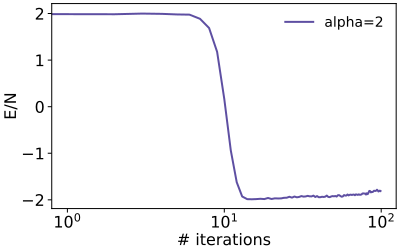

In [96]:
plt.semilogx(E_ar)
plt.xlabel('# iterations')
plt.ylabel('E/N')
plt.legend(['alpha=2'])
plt.tick_params(axis='x', which='minor')

## Accuracy of the model

This model needs to be checked against the exact ground state energy to determine its accuracy. This is done with the following code which has been provided by sources $[3]$ & $[6]$.

In [84]:
%%time
from itertools import product

N=12
basis = list(product([-1,1],repeat=N))

print('Generated %d basis functions' % (len(basis)))
#print(len(basis_functions))

#list(permutations([0,1,0,0]))
H = np.zeros((2**N,2**N))
for H_i in range(2**N):
    for H_j in range(2**N):
        H_sum = 0
        for i in range(N):
            if H_i == H_j:
                if i == N-1:
                    H_sum -= basis[H_j][i]*basis[H_j][0]
                else:
                    H_sum -= basis[H_j][i]*basis[H_j][i+1]
                    
            sj = list(basis[H_j])
            sj[i] *= -1
            if H_i == basis.index(tuple(sj)):
                H_sum -= h

        H[H_i,H_j] = H_sum

E_exact=np.min(np.linalg.eigvals(H))/N
print('Ground state energy:', E_exact)

Generated 4096 basis functions
Ground state energy: (-2.127094858504017+0j)
Wall time: 1h 54min 3s


In [93]:
last=len(E_ar)-1
E_rel=(np.min(E_ar)-E_exact)/np.abs(E_exact)
print(E_rel)

(0.06526934672301662+0j)


(-2.15, -1.8)

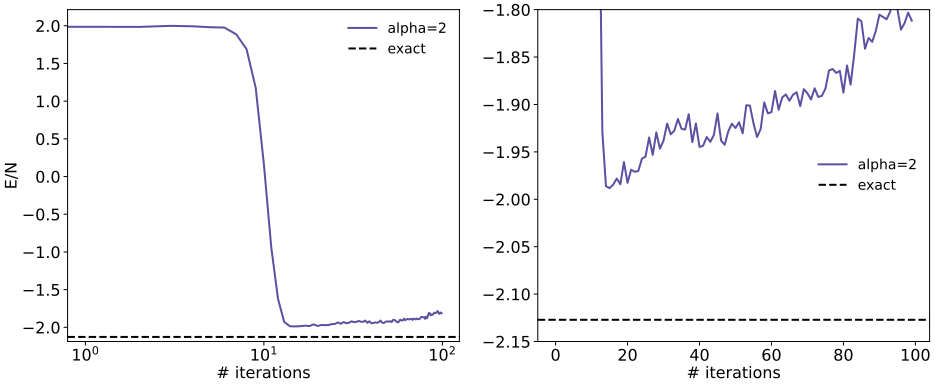

In [128]:
fig,ax=plt.subplots(1,2,sharex=False,figsize=(15,6))
ax[0].semilogx(E_ar)
ax[0].set_xlabel('# iterations')
ax[0].set_ylabel('E/N')
ax[0].axhline(E_exact,color='k',linestyle='dashed',label='Exact')
ax[0].legend(['alpha=2','exact'])

ax[1].plot(E_ar)
ax[1].set_xlabel('# iterations')
ax[1].axhline(E_exact,color='k',linestyle='dashed',label='Exact')
ax[1].legend(['alpha=2','exact'])

ax[1].set_ylim(-2.15,-1.8)

## Results

From the graphs, it can be seen that the lowest relative error is 0.065. This can be seen from the initial drop around 10 iterations. Then there appears to be another minimum around -1, which leads to the slight increase in the value of E/N. My initial goal was to recreate the following graph, which was for the 1D Heisenberg Hamiltonian. I followed this process but for the Transverse-field Ising Hamiltonian. It came out with a somewhat similar result, so I consider this a somewhat successful project.

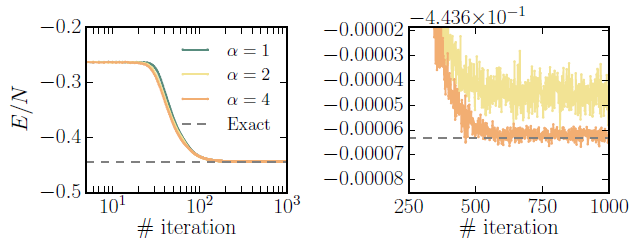

In [131]:
Image('fig3.png')

Source: $[1]$

## Future Work  

This can be improved by solving the $\Psi_M$ equation so that it can be put into an autodifferentiator, such as jax. 

Another point of improvement would be setting the initial E/N value to be negative. This would be done soley after seeing what the exact value is for these systems. 

Futher implementation would be a different optimization equation for the updating of the weights. This could also be tied into the implementation of a variable learning rate like in the reference paper $[1]$.

## References
$[1]$ Carleo, G. & Troyer, M. Solving the Quantum Many-Body Problem with Aritificial Neural Networks. arXiv:1606.02318 $[cond-mat.dis-nn]$ (2016).

$[2]$ Deng, D., Xiaopeng, L., & Sarma, S. D. Machine learning topological states.  arXiv:1609.09060v2 $[cond-mat.dis-nn]$ (2017).

$[3]$ Carleo, G. Personal Communications (2021).

$[4]$ “Many-Body Problem.” Wikipedia, Wikimedia Foundation, 9 Mar. 2021, en.wikipedia.org/wiki/Many-body_problem. https://en.wikipedia.org/wiki/Many-body_problem#:~:text=The%20many%2Dbody%20problem%20is,made%20of%20many%20interacting%20particles.&text=In%20such%20a%20quantum%20system,create%20quantum%20correlations%2C%20or%20entanglement.

$[5]$ Lindsey, M. (2019). The Quantum Many-Body Problem: Methods and Analysis. UC Berkeley. ProQuest ID: Lindsey_berkeley_0028E_19068. Merritt ID: ark:/13030/m53r60m7. Retrieved from https://escholarship.org/uc/item/8cc708cd

$[6]$ Giuseppe Carleo, Kenny Choo, Damian Hofmann, James E.T. Smith, Tom Westerhout, Fabien Alet, Emily J. Davis, Stavros Efthymiou, Ivan Glasser, Sheng-Hsuan Lin, Marta Mauri, Guglielmo Mazzola, Christian B. Mendl, Evert van Nieuwenburg, Ossian O’Reilly, Hugo Théveniaut, Giacomo Torlai, Filippo Vicentini, Alexander Wietek,
NetKet: A machine learning toolkit for many-body quantum systems,
SoftwareX,
Volume 10,
2019,
100311,
ISSN 2352-7110,
https://doi.org/10.1016/j.softx.2019.100311.
(https://www.sciencedirect.com/science/article/pii/S2352711019300974)